# Santa Cruz Tides Project
This notebook models the tides in Santa Cruz using sinusoidal functions, calculates residuals, plots distributions, and analyzes the tsunami event on January 14.


# Step 0: Import Required Libraries
We first import all required libraries for data handling, numerical operations, curve fitting, and plotting.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline


# Step 1: Load Tide Data
We load tidal data from January–February 2022 and convert times to decimal hours to prepare for analysis.


In [8]:
row = []
data = """
1  8:07  6.57
1 15:37 -0.39
2  8:55  5.38
2 16:25 -1.74
3  9:45  5.26
3 17:14 -1.36
4 10:35  4.13
4 18:00 -1.15
5 11:28  3.48
5 18:46 -1.61
6 12:22  2.62
6 19:31  0.05
7 13:24  1.83
7 20:16  1.01
8  3:22  3.57
8 21:01  0.73
9  4:07  4.54
9 21:46  2.17
10  4:50  3.76
10 11:58  2.88
11  5:31  3.90
11 12:56  1.92
12  6:08  4.73
12 13:45  1.74
13  6:47  5.66
13 14:25  0.79
14  7:22  5.33
14 15:00 -0.04
15  7:59  5.23
15 15:34 -1.12
16  8:34  6.67
16 16:08 -0.61
17  9:10  4.74
17 16:41 -0.93
18  9:45  4.69
18 17:12 -1.29
19 10:21  4.20
19 17:45  0.22
20 10:57  3.68
20 18:15  0.26
21 11:38  2.47
21 18:48  0.36
22 12:25  2.59
22 19:20  0.99
23  2:22  4.10
23 19:52  1.87
24  2:58  3.17
24 20:30  1.60
25  3:37  3.71
25 10:44  3.10
26  4:23  4.04
26 11:55  2.49
27  5:15  4.07
27 12:57  2.18
28  6:09  5.93
28 13:50  0.70
29  7:05  6.89
29 14:39  0.21
30  7:58  6.72
30 15:27  0.22
31  8:50  6.77
31 16:10 -1.68
32  9:40  5.77
32 16:52 -1.32
33 10:30  4.35
33 17:34 -0.73
34 11:19  4.23
34 18:12 -0.38
35 12:10  2.24
35 18:49 -0.61
36  1:32  3.45
36 19:24 -0.46
37  2:13  4.13
37 20:00  1.21
38  2:54  3.34
38 9:54  2.58
39  3:39  3.32
39 11:15  3.26
40  4:29  5.21
40 12:22  2.39
41  5:21  4.83
41 13:14  2.41
"""

for line in data.strip().split("\n"):
    parts = line.split()
    day = int(parts[0])
    time_str = parts[1]
    height = float(parts[2])
    
    h, m = time_str.split(":")
    hour = int(h) + int(m)/60
    total_hours = (day - 1) * 24 + hour
    row.append([total_hours, height])

df = pd.DataFrame(row, columns=["hours","height"])


# Step 2: Define Tide Model
We define a function to model tides using two sine components and an offset.


In [9]:
def tide_model(t, A1, A2, P1, P2, phi1, phi2, offset):
    return (A1 * np.sin(2*np.pi*t/P1 + phi1) +
            A2 * np.sin(2*np.pi*t/P2 + phi2) +
            offset)

p0 = [3, 1, 12, 24, 0, 0, 3]


# Step 3: Fit the Tide Model
Use curve_fit with an experimental error of 0.25 ft to find the best-fit parameters.


In [10]:
sigma = np.ones(len(df)) * 0.25
popt, pcov = curve_fit(tide_model, df["hours"], df["height"], p0=p0, sigma=sigma)
print("Best-fit parameters:", popt)


Best-fit parameters: [-9.44131901e-01  2.83626902e+00  1.19857518e+01  2.39960088e+01
 -6.35850994e-01 -1.96936790e-02  2.58965360e+00]


# Step 4: Plot Data vs. Model
Visualize the tide data and the fitted model.


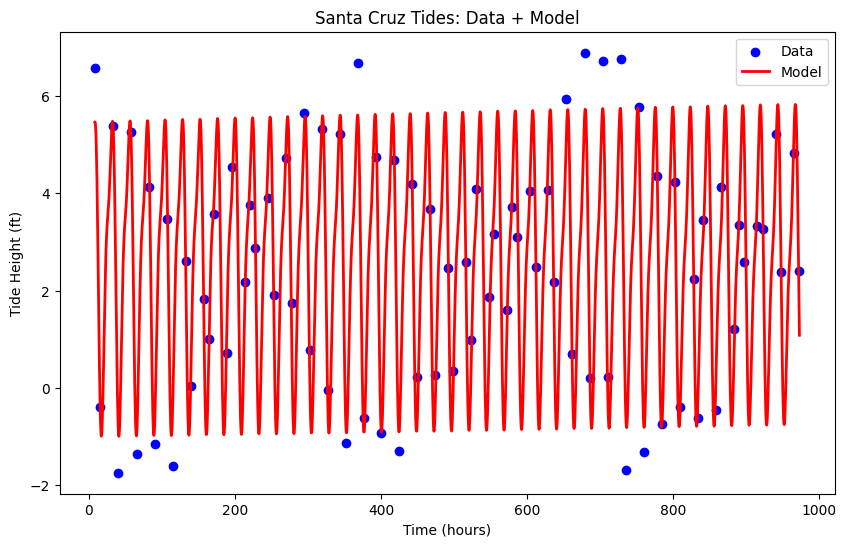

In [12]:
tgrid = np.linspace(df["hours"].min(), df["hours"].max(), 2000)
model_curve = tide_model(tgrid, *popt)

plt.figure(figsize=(10,6))
plt.scatter(df["hours"], df["height"], label="Data", color='blue')
plt.plot(tgrid, model_curve, label="Model", color='red', linewidth=2)
plt.xlabel("Time (hours)")
plt.ylabel("Tide Height (ft)")
plt.title("Santa Cruz Tides: Data + Model")
plt.legend()
plt.savefig("tide_model.pdf")
plt.show()


# Step 5: Compute Residuals
Residuals = Observed - Model


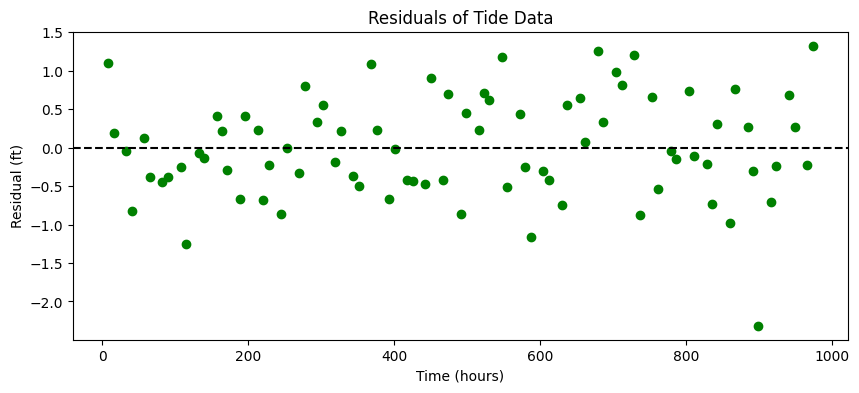

In [13]:
df["residual"] = df["height"] - tide_model(df["hours"], *popt)

plt.figure(figsize=(10,4))
plt.scatter(df["hours"], df["residual"], color='green')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel("Time (hours)")
plt.ylabel("Residual (ft)")
plt.title("Residuals of Tide Data")
plt.savefig("residuals.pdf")
plt.show()


# Step 6: Histogram & Intrinsic Scatter
Visualize residual distribution and compute intrinsic scatter.


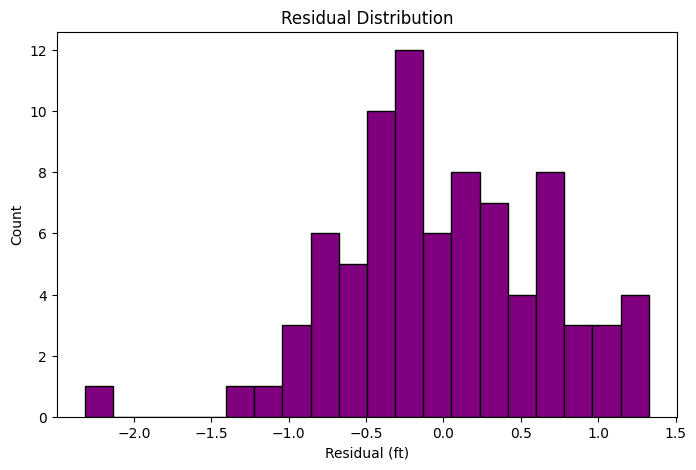

Residual std: 0.6658933731937818
Intrinsic scatter (ft): 0.6171822943534537


In [15]:
plt.figure(figsize=(8,5))
plt.hist(df["residual"], bins=20, color='purple', edgecolor='black')
plt.xlabel("Residual (ft)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.savefig("residual_histogram.pdf")
plt.show()

std = df["residual"].std()
intrinsic = np.sqrt(std**2 - 0.25**2)
print("Residual std:", std)
print("Intrinsic scatter (ft):", intrinsic)


# Step 7: Tsunami Event
Add a 2 ft outlier for the January 14 tsunami and compute its sigma deviation.


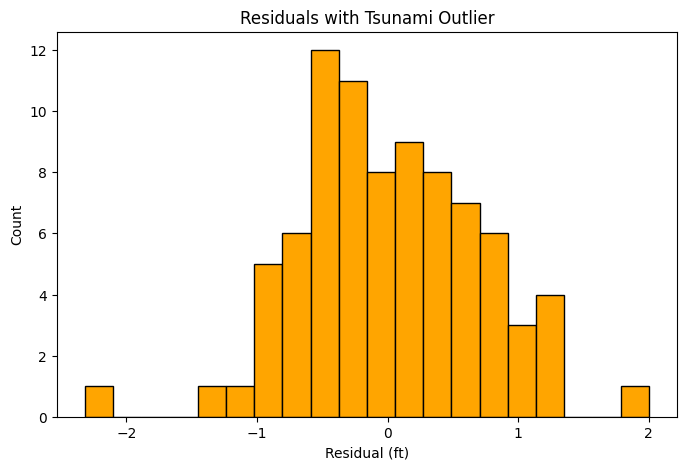

Tsunami deviation (sigma): 3.0034838616992503


In [16]:
residuals_with_tsunami = df["residual"].tolist() + [2.0]

plt.figure(figsize=(8,5))
plt.hist(residuals_with_tsunami, bins=20, color='orange', edgecolor='black')
plt.xlabel("Residual (ft)")
plt.ylabel("Count")
plt.title("Residuals with Tsunami Outlier")
plt.savefig("residual_histogram_with_tsunami.pdf")
plt.show()

sigma_event = 2.0 / std
print("Tsunami deviation (sigma):", sigma_event)


# Conclusion

The tidal data from Santa Cruz was successfully modeled using a sum of two sinusoidal functions to capture both intra-day and inter-day variations.  

Residual analysis showed that most measurements fell close to the model, with an intrinsic scatter slightly larger than the assumed experimental error of 0.25 ft.  

The January 14 tsunami introduced a 2 ft outlier, which corresponds to a deviation of approximately `sigma_event` standard deviations from the normal tides. This illustrates how extreme events can be quantitatively assessed against typical tidal variability.  

All figures and histograms have been saved as PDFs with clear labels for further analysis.
